In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import h5py
import pandas as pd
import numpy as np
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
f = h5py.File('./data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z', 'r')
treeArray = f['t_allpar_new'][()]

In [3]:
features = ['j1_ptrel','j1_etarot','j1_phirot','j_index']
labels = ['j_g','j_q','j_w','j_z','j_t','j_index']

In [4]:
features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))
df = pd.concat([features_df,labels_df],axis=1)
df = df.drop_duplicates()

In [5]:
# Convert to nparray
bins = [40,40]
Xrange=[-0.8,0.8]
yrange = [-1,1]
L1Reg =  0.0001


labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

features_2dval = np.zeros((len(labels_df), bins[0], bins[1], 1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    xbins = np.linspace(Xrange[0], Xrange[1], bins[0] + 1)
    ybins = np.linspace(yrange[0], yrange[1], bins[1] + 1)

    x = features_df_i[features[0]]
    y = features_df_i[features[1]]
    w = features_df_i[features[2]]

    hist, xedges, yedges = np.histogram2d(x, y, weights=w, bins=(xbins, ybins))

    for ix in range(0, bins[0]):
        for iy in range(0, bins[1]):
            features_2dval[i, ix, iy, 0] = hist[ix, iy]
features_val = features_2dval

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2,random_state=42)

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=(11,11), strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu',
               activation = 'relu',input_shape=(40,40,1)))
model.add(layers.Conv2D(filters=4, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu',
               activation = 'relu'))
model.add(layers.Conv2D(filters=2, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv3_relu',
               activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc1_relu', kernel_regularizer=l1(L1Reg)))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(L1Reg)))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_relu (Conv2D)          (None, 40, 40, 8)         976       
_________________________________________________________________
conv2_relu (Conv2D)          (None, 20, 20, 4)         292       
_________________________________________________________________
conv3_relu (Conv2D)          (None, 10, 10, 2)         74        
_________________________________________________________________
flatten_2 (Flatten)          (None, 200)               0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                6432      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165       
Total params: 7,939
Trainable params: 7,939
Non-trainable params: 0
____________________________________________________

In [11]:
learningRate = 1e-4
adam = Adam(lr=learningRate)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(X_train_val, y_train_val, epochs=100, batch_size=1024, validation_split=0.25, shuffle=True)

Train on 14889 samples, validate on 4963 samples
Epoch 1/100
14889/14889 [==============================] - 10s 700us/sample - loss: 0.1387 - accuracy: 0.9542 - val_loss: 0.1382 - val_accuracy: 0.9549
Epoch 2/100
14889/14889 [==============================] - 10s 694us/sample - loss: 0.1382 - accuracy: 0.9548 - val_loss: 0.1377 - val_accuracy: 0.9553
Epoch 3/100
14889/14889 [==============================] - 10s 701us/sample - loss: 0.1373 - accuracy: 0.9551 - val_loss: 0.1375 - val_accuracy: 0.9553
Epoch 4/100
14889/14889 [==============================] - 11s 709us/sample - loss: 0.1366 - accuracy: 0.9552 - val_loss: 0.1367 - val_accuracy: 0.9551
Epoch 5/100
14889/14889 [==============================] - 10s 699us/sample - loss: 0.1359 - accuracy: 0.9553 - val_loss: 0.1362 - val_accuracy: 0.9561
Epoch 6/100
14889/14889 [==============================] - 10s 701us/sample - loss: 0.1355 - accuracy: 0.9561 - val_loss: 0.1365 - val_accuracy: 0.9547
Epoch 7/100
14889/14889 [==============

14889/14889 [==============================] - 10s 703us/sample - loss: 0.1067 - accuracy: 0.9656 - val_loss: 0.1158 - val_accuracy: 0.9633
Epoch 55/100
14889/14889 [==============================] - 11s 725us/sample - loss: 0.1059 - accuracy: 0.9663 - val_loss: 0.1139 - val_accuracy: 0.9631
Epoch 56/100
14889/14889 [==============================] - 10s 691us/sample - loss: 0.1050 - accuracy: 0.9666 - val_loss: 0.1187 - val_accuracy: 0.9629
Epoch 57/100
14889/14889 [==============================] - 10s 693us/sample - loss: 0.1051 - accuracy: 0.9668 - val_loss: 0.1143 - val_accuracy: 0.9637
Epoch 58/100
14889/14889 [==============================] - 10s 687us/sample - loss: 0.1043 - accuracy: 0.9669 - val_loss: 0.1139 - val_accuracy: 0.9639
Epoch 59/100
14889/14889 [==============================] - 10s 698us/sample - loss: 0.1039 - accuracy: 0.9673 - val_loss: 0.1135 - val_accuracy: 0.9631
Epoch 60/100
14889/14889 [==============================] - 11s 714us/sample - loss: 0.1039 - a

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Text(0.25, 0.9, 'Conv_2d')

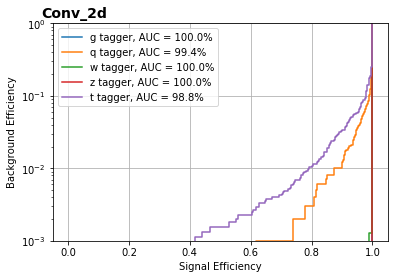

In [18]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_2d',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)